In [16]:
# Imports
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn_evaluation import plot
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

In [17]:
# Read CSV from https://www.kaggle.com/datasets/shubh0799/churn-modelling
df_csv = pd.read_csv('Churn_Modeling.csv')
df_csv.isna().describe()
# No N/A to deal with

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Number of Records
count,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
unique,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000


In [18]:
df_csv.describe()
# Initial distributions of features

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Number of Records
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.0
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700,1.0
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769,0.0
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,1.0
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,1.0
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,1.0
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,1.0
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.0


<AxesSubplot:xlabel='Age', ylabel='Count'>

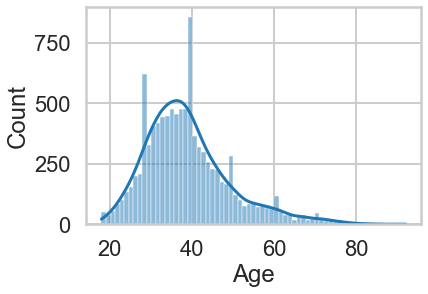

In [19]:
sns.histplot(data = df_csv['Age'], kde = True)
# Age median seen around spike at 40

<AxesSubplot:>

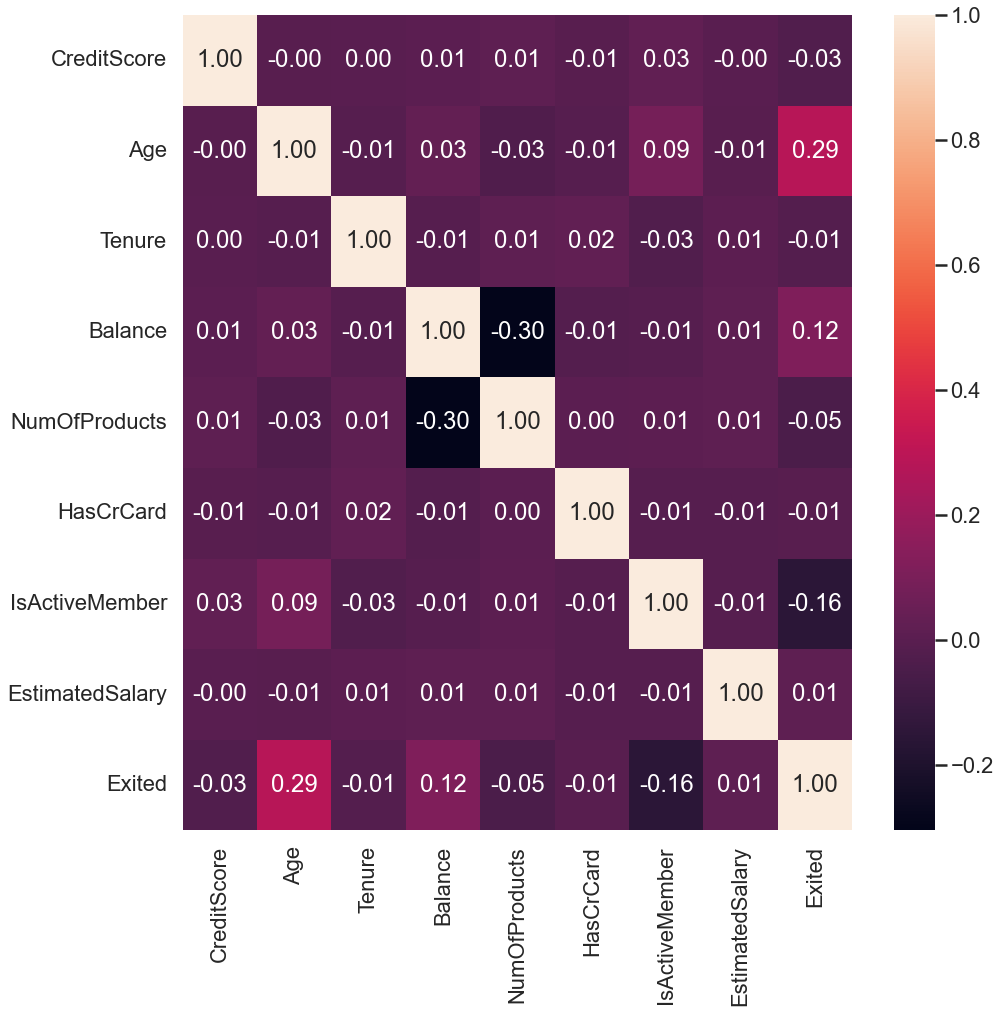

In [20]:
fig, ax = plt.subplots(figsize=(15,15))
#sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)

sns.heatmap(df_csv[['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 
        'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
        'EstimatedSalary', 'Exited']].corr(), annot=True, fmt=".2f", ax=ax)
# Heatmap of correlation show Age and Balance as highest corr to Exited

In [21]:
print(len(df_csv['Surname'].unique()))
print(df_csv['Geography'].unique())
print(df_csv['Gender'].unique())
print(len(df_csv['CustomerId'].unique()))
print(df_csv.dtypes)

# We see that:
# Row number is simply ascending 1 to 10,000
# Surname is 2,932 unique values in 10,000 rows
# Geography has 3 unique countries represented
# Gender has 2 unique genders represented
# Customer ID is 10,000 unique values in 10,000 rows of the df
# Credit score is from 350 to 850, integers only
# Age is from 18 to 92, integers only
# Tenure is from 0 to 10, integers only
# Balance is from 0 to ~251,000, float value
# NumOfProducts is from 1 to 4, integers only
# HasCrCard is boolean
# IsActiveMember is boolean
# Estimated Salary is ~11.6 to ~200,000, float value
# Exited is boolean

2932
['France' 'Spain' 'Germany']
['Female' 'Male']
10000
RowNumber              int64
CustomerId             int64
Surname               object
CreditScore            int64
Geography             object
Gender                object
Age                    int64
Tenure                 int64
Balance              float64
NumOfProducts          int64
HasCrCard              int64
IsActiveMember         int64
EstimatedSalary      float64
Exited                 int64
Number of Records      int64
dtype: object


In [22]:
df_csv[df_csv['IsActiveMember']==df_csv['Exited']]
# There are cases (43% of data) of inactive members that have not exited or active memebers that have exited
# 'Exited' column will be used as the target variable

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Number of Records
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,1
10,11,15767821,Bearce,528,France,Male,31,6,102016.72,2,0,0,80181.12,0,1
11,12,15737173,Andrews,497,Spain,Male,24,3,0.00,2,1,0,76390.01,0,1
12,13,15632264,Kay,476,France,Female,34,10,0.00,2,1,0,26260.98,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,9994,15569266,Rahman,644,France,Male,28,7,155060.41,1,1,0,29179.52,0,1
9994,9995,15719294,Wood,800,France,Female,29,2,0.00,2,0,0,167773.55,0,1
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0,1
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1,1


In [23]:
df_csv['Exited'].value_counts()
# ~80% of customers have not exited, we will need to deal with class imbalance

0    7963
1    2037
Name: Exited, dtype: int64

In [24]:
## One hot encode Geography and Gender, scale float features to 0-1
# RowNumber, drop
# Surname, drop
# Geography, one hot
# Gender, one hot
# Customer ID, index
# Credit score, scale
# Age, scale
# Tenure, scale
# Balance, scale
# NumOfProducts scale
# HasCrCard, none
# IsActiveMember none
# EstimatedSalary, scale
# Exited, target

oh_encode = ce.one_hot.OneHotEncoder(cols=
    ['Geography', 'Gender'], use_cat_names=True)
df_encode= oh_encode.fit_transform(df_csv)

scaler = MinMaxScaler()
df_encode[['CreditScore_Scaled', 'Age_Scaled', 'Tenure_Scaled', 'Balance_Scaled', 'NumOfProducts_Scaled', 'EstimatedSalary_Scaled']] =\
    scaler.fit_transform(df_encode[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']])

df_encode.set_index('CustomerId', inplace=True)
df_encode.drop(['RowNumber', 'Surname', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary'], axis=1, inplace=True)

df_encode.head()

,Geography_France,Geography_Spain,Geography_Germany,Gender_Female,Gender_Male,HasCrCard,IsActiveMember,Exited,Number of Records,CreditScore_Scaled,Age_Scaled,Tenure_Scaled,Balance_Scaled,NumOfProducts_Scaled,EstimatedSalary_Scaled
CustomerId,,,,,,,,,,,,,,,
15634602,1,0,0,1,0,1,1,1,1,0.538,0.324324,0.2,0.000000,0.000000,0.506735
15647311,0,1,0,1,0,0,1,0,1,0.516,0.310811,0.1,0.334031,0.000000,0.562709
15619304,1,0,0,1,0,1,0,1,1,0.304,0.324324,0.8,0.636357,0.666667,0.569654
15701354,1,0,0,1,0,0,0,0,1,0.698,0.283784,0.1,0.000000,0.333333,0.469120
15737888,0,1,0,1,0,1,1,0,1,1.000,0.337838,0.2,0.500246,0.000000,0.395400


In [25]:
# Train test split at 70%
X = df_encode[['CreditScore_Scaled', 'Age_Scaled', 'NumOfProducts_Scaled', 'Balance_Scaled',
       'EstimatedSalary_Scaled', 'Tenure_Scaled', 'HasCrCard', 'IsActiveMember',
       'Gender_Female', 'Gender_Male', 
       'Geography_France', 'Geography_Spain', 'Geography_Germany',]]

y = df_encode['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

In [26]:
# Target encoding for boolean features
tar_enc = ce.TargetEncoder(cols=['HasCrCard', 'IsActiveMember',
       'Geography_France', 'Geography_Spain', 'Geography_Germany',
       'Gender_Female', 'Gender_Male'],
       min_samples_leaf=5, smoothing=3).fit(X_train, y_train)
X_train = tar_enc.transform(X_train)
X_test = tar_enc.transform(X_test)

In [27]:
# Grid Search from: https://stackoverflow.com/questions/38151615/specific-cross-validation-with-random-forest
clf = RandomForestClassifier()  
param_grid = {'n_estimators': [50,100,150,200,250], 'max_depth': [10,None], 'max_features': [3,5,8,11,None],
    'min_samples_leaf': [1,3,6,10]}

grid_clf = GridSearchCV(clf, param_grid, cv=5)
grid_clf.fit(X_train, y_train)

print(grid_clf.best_estimator_)

RandomForestClassifier(max_features=5, min_samples_leaf=6, n_estimators=150)


In [28]:
cv_res = pd.DataFrame(grid_clf.cv_results_)
cv_res[cv_res['rank_test_score']<=5].sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
132,1.277012,0.059262,0.059644,0.019210,None,5,6,150,"{'max_depth': None, 'max_features': 5, 'min_sa...",0.853571,0.880714,0.874286,0.865000,0.863571,0.867429,0.009342,1
108,2.208110,0.088296,0.123237,0.007998,None,3,3,200,"{'max_depth': None, 'max_features': 3, 'min_sa...",0.858571,0.877857,0.866429,0.867143,0.864286,0.866857,0.006269,2
21,0.965954,0.037755,0.041314,0.018117,10,5,1,100,"{'max_depth': 10, 'max_features': 5, 'min_samp...",0.860000,0.877857,0.869286,0.865714,0.860000,0.866571,0.006661,3
20,0.409839,0.043027,0.018994,0.005133,10,5,1,50,"{'max_depth': 10, 'max_features': 5, 'min_samp...",0.854286,0.880000,0.870000,0.866429,0.860000,0.866143,0.008778,4
128,2.688607,0.515692,0.141078,0.034849,None,5,3,200,"{'max_depth': None, 'max_features': 5, 'min_sa...",0.855000,0.877857,0.871429,0.860000,0.866429,0.866143,0.008089,5


ACCURACY:  0.8606666666666667
PRECISION:  0.7816091954022989
RECALL:  0.44299674267100975
F1:  0.5654885654885654


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

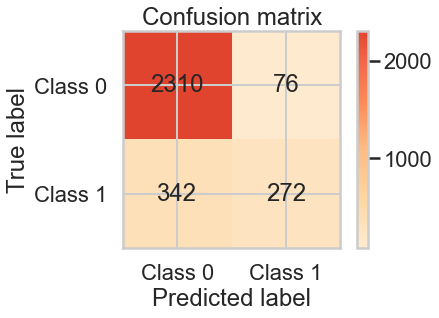

In [29]:
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf = RandomForestClassifier(max_depth = 10, min_samples_leaf=1,
    max_features=5, n_estimators=100)
clf.fit(X_train, y_train)
  
# performing predictions on the test dataset
y_pred = clf.predict(X_test)

# using metrics module for accuracy calculation
print('ACCURACY: ', metrics.accuracy_score(y_test, y_pred))
print('PRECISION: ', metrics.precision_score(y_test, y_pred))
print('RECALL: ', metrics.recall_score(y_test, y_pred))
print('F1: ', metrics.f1_score(y_test, y_pred))
plot.confusion_matrix(y_test, y_pred)
# ~80% of customers have not exited, try SMOTE or Tomek?
# Strong bias to unexited customers, 50/50 on exited customers

Text(0, 0.5, 'Mean decrease in impurity')

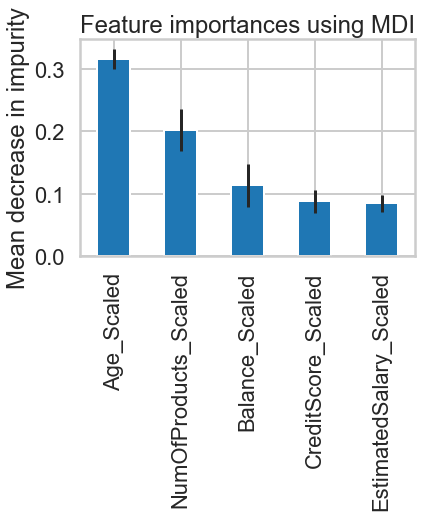

In [35]:
# Feature Importance, strongest predictors seen are: age, num products, balance, credit score
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
import matplotlib.pyplot as plt
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances[0:5].plot.bar(yerr=std[0:5], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")